In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

def load_and_prepare_data():
    # Read Excel file with the specific name
    print("Reading Excel file 'Online_Sales_CLV.xlsx'...")
    try:
        df = pd.read_excel('Online_Sales_CLV.xlsx')
        print("File loaded successfully!")
    except Exception as e:
        print(f"Error loading file: {str(e)}")
        return None

    # Convert Transaction_Date to datetime
    df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])

    # Calculate total amount per transaction
    df['Total_Amount'] = df['Quantity'] * df['Avg_Price'] + df['Delivery_Charges']

    return df

def calculate_rfm(df):
    # Calculate the most recent date in the dataset
    max_date = df['Transaction_Date'].max()

    # Group by customer and calculate RFM metrics
    rfm = df.groupby('CustomerID').agg({
        'Transaction_Date': lambda x: (max_date - x.max()).days,  # Recency
        'Transaction_ID': 'count',  # Frequency
        'Total_Amount': 'sum'  # Monetary
    }).rename(columns={
        'Transaction_Date': 'Recency',
        'Transaction_ID': 'Frequency',
        'Total_Amount': 'Monetary'
    })

    return rfm

def score_rfm(rfm):
    # Create quartiles for each RFM metric
    r_labels = range(4, 0, -1)  # 4 is best, 1 is worst for recency
    f_labels = range(1, 5)  # 1 is worst, 4 is best for frequency
    m_labels = range(1, 5)  # 1 is worst, 4 is best for monetary

    # Using pd.qcut with handling for duplicate values
    r_quartiles = pd.qcut(rfm['Recency'], q=4, labels=r_labels, duplicates='drop')
    f_quartiles = pd.qcut(rfm['Frequency'], q=4, labels=f_labels, duplicates='drop')
    m_quartiles = pd.qcut(rfm['Monetary'], q=4, labels=m_labels, duplicates='drop')

    rfm['R'] = r_quartiles
    rfm['F'] = f_quartiles
    rfm['M'] = m_quartiles

    # Calculate RFM Score
    rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
    rfm['RFM_Value'] = rfm[['R', 'F', 'M']].mean(axis=1)

    return rfm

def segment_customers(rfm):
    def segment_label(value):
        if value >= 3.5: return 'Champion Customers'
        elif value >= 2.5: return 'Loyal Customers'
        elif value >= 2: return 'Average Customers'
        else: return 'At Risk Customers'

    rfm['Customer_Segment'] = rfm['RFM_Value'].apply(segment_label)
    return rfm

def calculate_clv(rfm, time_period=12):
    # Calculate average monthly value
    rfm['Monthly_Value'] = rfm['Monetary'] / time_period

    # Calculate CLV
    rfm['CLV'] = rfm['Monthly_Value'] * rfm['RFM_Value'] * time_period

    return rfm

    # 1. Customer Segments Distribution
    plt.figure(figsize=(12, 6))
    plt.title('Distribution of Customer Segments', fontsize=14, pad=20)
    segment_dist = sns.countplot(data=rfm, x='Customer_Segment',
                               order=rfm['Customer_Segment'].value_counts().index)

    # Add value labels
    for p in segment_dist.patches:
        segment_dist.annotate(f'{int(p.get_height())}',
                            (p.get_x() + p.get_width()/2., p.get_height()),
                            ha='center', va='bottom')

    plt.xlabel('Customer Segment', fontsize=12)
    plt.ylabel('Number of Customers', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Average CLV by Segment
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=rfm, x='Customer_Segment', y='CLV',
                order=['Champion Customers', 'Loyal Customers',
                       'Average Customers', 'At Risk Customers'])
    plt.title('Customer Lifetime Value Distribution by Segment', fontsize=14)
    plt.xlabel('Customer Segment', fontsize=12)
    plt.ylabel('Customer Lifetime Value ($)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3. RFM Scatter Plot
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=rfm, x='Frequency', y='Monetary',
                            size='Recency', hue='Customer_Segment',
                            sizes=(50, 400), alpha=0.6)
    plt.title('Customer RFM Analysis', fontsize=14)
    plt.xlabel('Purchase Frequency', fontsize=12)
    plt.ylabel('Total Monetary Value ($)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def main():
    # Load and prepare data
    df = load_and_prepare_data()
    if df is None:
        return

    # Print initial insights
    print("\nDataset Overview:")
    print(f"Total number of transactions: {len(df):,}")
    print(f"Number of unique customers: {df['CustomerID'].nunique():,}")
    print(f"Date range: {df['Transaction_Date'].min().strftime('%Y-%m-%d')} to {df['Transaction_Date'].max().strftime('%Y-%m-%d')}")

    # Calculate RFM and segment customers
    rfm = calculate_rfm(df)
    rfm = score_rfm(rfm)
    rfm = segment_customers(rfm)
    rfm = calculate_clv(rfm)

    # Print summary statistics
    print("\nCustomer Segment Summary:")
    segment_summary = rfm.groupby('Customer_Segment').agg({
        'CLV': ['count', 'mean', 'sum'],
        'RFM_Value': 'mean'
    }).round(2)

    print(segment_summary)



    # Export results
    output_file = 'CLV_Analysis_Results.xlsx'
    rfm.to_excel(output_file)
    print(f"\nAnalysis complete! Detailed results exported to '{output_file}'")

    return rfm

if __name__ == "__main__":
    rfm_results = main()

Reading Excel file 'Online_Sales_CLV.xlsx'...
File loaded successfully!

Dataset Overview:
Total number of transactions: 52,924
Number of unique customers: 1,468
Date range: 2019-01-01 to 2019-12-31

Customer Segment Summary:
                     CLV                       RFM_Value
                   count      mean         sum      mean
Customer_Segment                                        
At Risk Customers    405    846.69   342909.34      1.39
Average Customers    351   3271.24  1148205.28      2.17
Champion Customers   241  40970.53  9873898.11      3.83
Loyal Customers      471  12472.36  5874480.29      2.99

Analysis complete! Detailed results exported to 'CLV_Analysis_Results.xlsx'


Loading and preparing data...
Reading Excel file 'Online_Sales_CLV.xlsx'...
File loaded successfully!

Dataset Overview:
Total number of transactions: 52,924
Number of unique customers: 1,468
Date range: 2019-01-01 to 2019-12-31

Calculating RFM metrics...
Scoring RFM metrics...
Segmenting customers...
Calculating CLV...

Customer Segment Summary:

Segment Statistics:
                     CLV                       RFM_Value
                   count      mean         sum      mean
Customer_Segment                                        
At Risk Customers    405    846.69   342909.34      1.39
Average Customers    351   3271.24  1148205.28      2.17
Champion Customers   241  40970.53  9873898.11      3.83
Loyal Customers      471  12472.36  5874480.29      2.99

Key Metrics by Segment:
                    Recency  Frequency  Monetary       CLV
Customer_Segment                                          
At Risk Customers    220.03       7.40    565.06    846.69
Average Customers    143.18 

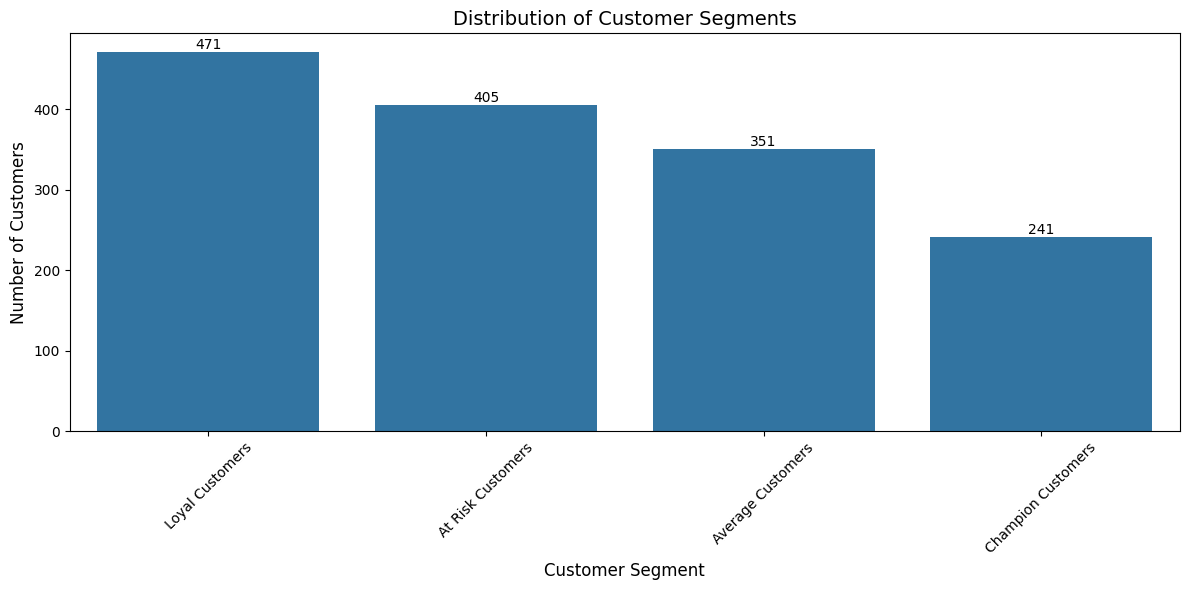

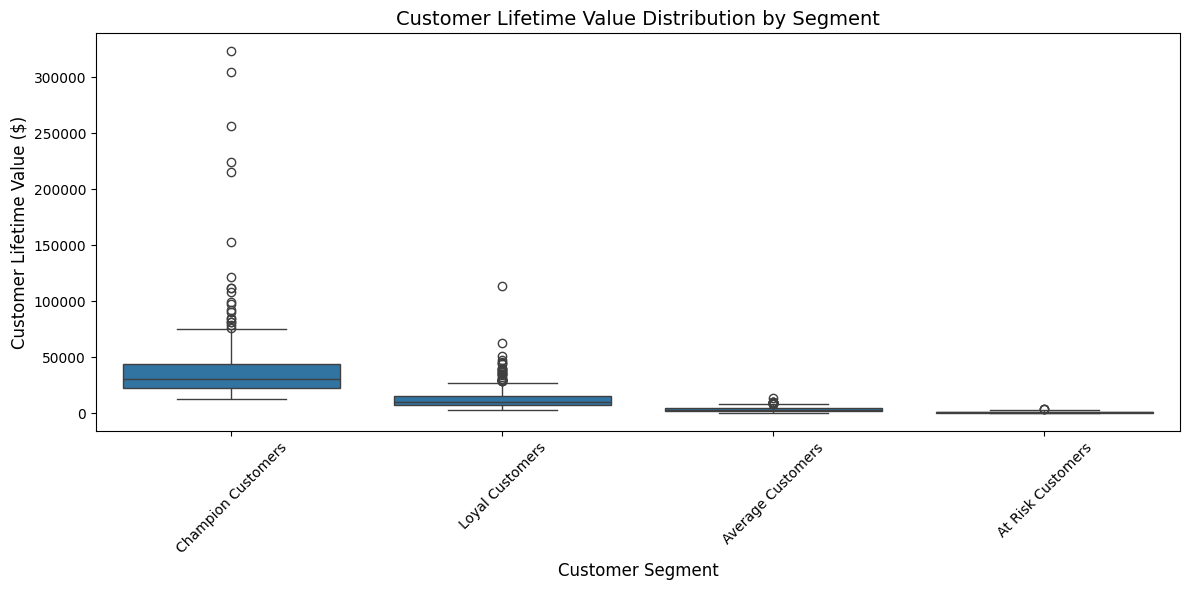

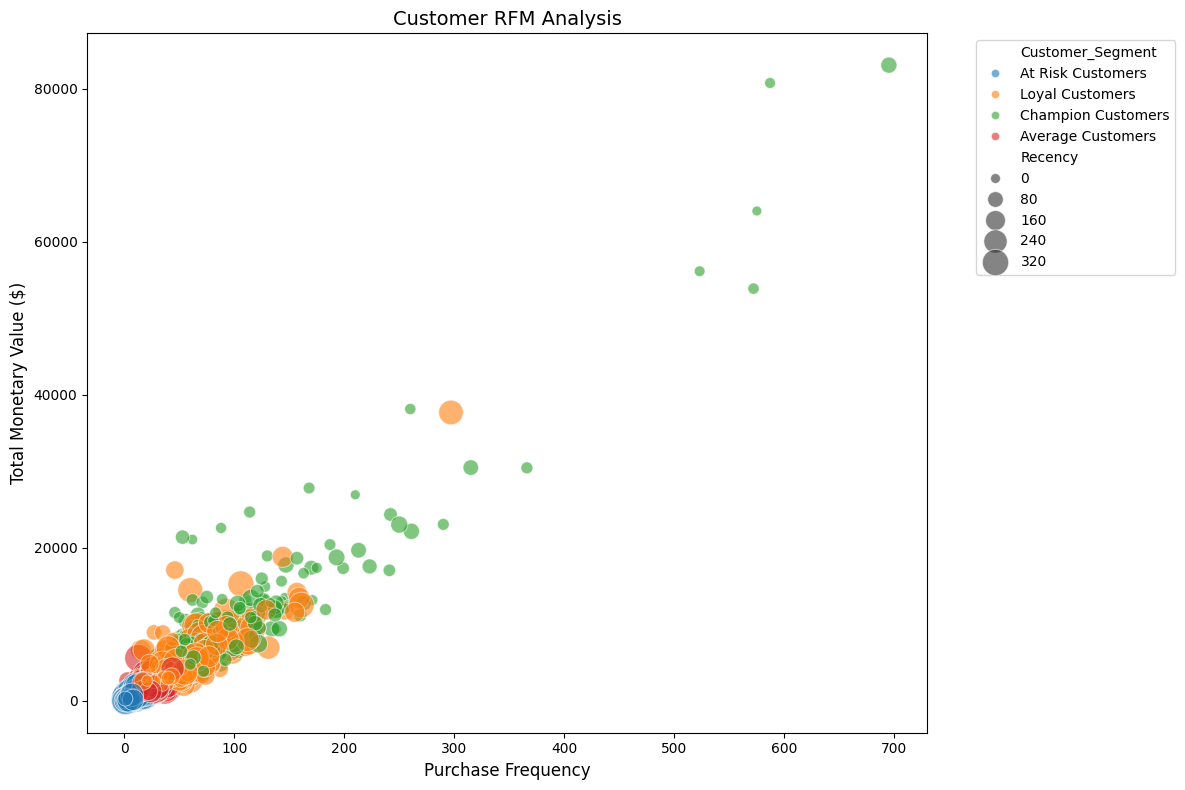


Analysis complete! Detailed results exported to 'CLV_Analysis_Results.xlsx'


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# ... (keep all previous functions the same until visualize_results)

def visualize_results(rfm):
    # 1. Customer Segments Distribution
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=rfm, x='Customer_Segment',
                      order=rfm['Customer_Segment'].value_counts().index)
    plt.title('Distribution of Customer Segments', fontsize=14)

    # Add value labels
    for i in ax.containers:
        ax.bar_label(i)

    plt.xlabel('Customer Segment', fontsize=12)
    plt.ylabel('Number of Customers', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. CLV Distribution by Segment
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=rfm, x='Customer_Segment', y='CLV',
                order=['Champion Customers', 'Loyal Customers',
                      'Average Customers', 'At Risk Customers'])
    plt.title('Customer Lifetime Value Distribution by Segment', fontsize=14)
    plt.xlabel('Customer Segment', fontsize=12)
    plt.ylabel('Customer Lifetime Value ($)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 3. RFM Scatter Plot with improved visibility
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=rfm, x='Frequency', y='Monetary',
                    size='Recency', hue='Customer_Segment',
                    sizes=(50, 400), alpha=0.6)
    plt.title('Customer RFM Analysis', fontsize=14)
    plt.xlabel('Purchase Frequency', fontsize=12)
    plt.ylabel('Total Monetary Value ($)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def main():
    try:
        # Load and prepare data
        print("Loading and preparing data...")
        df = load_and_prepare_data()

        if df is None:
            return

        # Print initial insights
        print("\nDataset Overview:")
        print(f"Total number of transactions: {len(df):,}")
        print(f"Number of unique customers: {df['CustomerID'].nunique():,}")
        print(f"Date range: {df['Transaction_Date'].min().strftime('%Y-%m-%d')} to {df['Transaction_Date'].max().strftime('%Y-%m-%d')}")

        # Calculate RFM and segment customers
        print("\nCalculating RFM metrics...")
        rfm = calculate_rfm(df)
        print("Scoring RFM metrics...")
        rfm = score_rfm(rfm)
        print("Segmenting customers...")
        rfm = segment_customers(rfm)
        print("Calculating CLV...")
        rfm = calculate_clv(rfm)

        # Print summary statistics
        print("\nCustomer Segment Summary:")
        segment_summary = rfm.groupby('Customer_Segment').agg({
            'CLV': ['count', 'mean', 'sum'],
            'RFM_Value': 'mean'
        }).round(2)

        print("\nSegment Statistics:")
        print(segment_summary)

        # Additional insights
        print("\nKey Metrics by Segment:")
        segment_metrics = rfm.groupby('Customer_Segment').agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': 'mean',
            'CLV': 'mean'
        }).round(2)
        print(segment_metrics)

        # Generate visualizations
        print("\nGenerating visualizations...")
        visualize_results(rfm)

        # Export results
        output_file = 'CLV_Analysis_Results.xlsx'
        rfm.to_excel(output_file)
        print(f"\nAnalysis complete! Detailed results exported to '{output_file}'")

        return rfm

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    rfm_results = main()